# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [20]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed

5 Failed downloads:
['GEV', 'VLTO', 'SW', 'SOLV', 'AMTM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


Price                              adj close       close        high  \
date                      ticker                                       
2015-09-29 00:00:00+00:00 A        31.375284   33.740002   34.060001   
                          AAPL     24.622631   27.264999   28.377501   
                          ABBV     36.004150   52.790001   54.189999   
                          ABT      33.302017   39.500000   40.150002   
                          ACGL     24.416668   24.416668   24.456667   
...                                      ...         ...         ...   
2023-09-26 00:00:00+00:00 XYL      88.501099   89.519997   90.849998   
                          YUM     121.604256  124.010002  124.739998   
                          ZBH     111.287468  112.459999  117.110001   
                          ZBRA    223.960007  223.960007  226.649994   
                          ZTS     175.131119  176.869995  178.449997   

Price                                    low        open       volume  
date                      ticker                                       
2015-09-29 00:00:00+00:00 A        33.240002   33.360001    2252400.0  
                          AAPL     26.965000   28.207500  293461600.0  
                          ABBV     51.880001   53.099998   12842800.0  
                          ABT      39.029999   39.259998   12287500.0  
                          ACGL     24.100000   24.170000    1888800.0  
...                                      ...         ...          ...  
2023-09-26 00:00:00+00:00 XYL      89.500000   90.379997    1322400.0  
                          YUM     123.449997  124.239998    1500600.0  
                          ZBH     112.419998  116.769997    3610500.0  
                          ZBRA    222.580002  225.970001     355400.0  
                          ZTS     176.270004  176.580002    1463200.0  

[982460 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [21]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                              adj close       close        high  \
date                      ticker                                       
2015-09-29 00:00:00+00:00 A        31.375284   33.740002   34.060001   
                          AAPL     24.622631   27.264999   28.377501   
                          ABBV     36.004150   52.790001   54.189999   
                          ABT      33.302017   39.500000   40.150002   
                          ACGL     24.416668   24.416668   24.456667   
...                                      ...         ...         ...   
2023-09-26 00:00:00+00:00 XYL      88.501099   89.519997   90.849998   
                          YUM     121.604256  124.010002  124.739998   
                          ZBH     111.287468  112.459999  117.110001   
                          ZBRA    223.960007  223.960007  226.649994   
                          ZTS     175.131119  176.869995  178.449997   

Price                                    low        open       volume  \
date                      ticker                                        
2015-09-29 00:00:00+00:00 A        33.240002   33.360001    2252400.0   
                          AAPL     26.965000   28.207500  293461600.0   
                          ABBV     51.880001   53.099998   12842800.0   
                          ABT      39.029999   39.259998   12287500.0   
                          ACGL     24.100000   24.170000    1888800.0   
...                                      ...         ...          ...   
2023-09-26 00:00:00+00:00 XYL      89.500000   90.379997    1322400.0   
                          YUM     123.449997  124.239998    1500600.0   
                          ZBH     112.419998  116.769997    3610500.0   
                          ZBRA    222.580002  225.970001     355400.0   
                          ZTS     176.270004  176.580002    1463200.0   

Price                             garman_klass_vol        rsi    bb_low  \
date                      ticker                                          
2015-09-29 00:00:00+00:00 A              -0.001156        NaN       NaN   
                          AAPL           -0.005833        NaN       NaN   
                          ABBV           -0.057368        NaN       NaN   
                          ABT            -0.010064        NaN       NaN   
                          ACGL            0.000068        NaN       NaN   
...                                            ...        ...       ...   
2023-09-26 00:00:00+00:00 XYL            -0.000058  26.146754  4.483137   
                          YUM            -0.000124  36.057147  4.806770   
                          ZBH            -0.000058  31.893213  4.743683   
                          ZBRA            0.000133  29.494977  5.400991   
                          ZTS             0.000049  42.623449  5.153746   

Price                               bb_mid   bb_high       atr      macd  \
date                      ticker                                           
2015-09-29 00:00:00+00:00 A            NaN       NaN       NaN       NaN   
                          AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
                          ACGL         NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2023-09-26 00:00:00+00:00 XYL     4.565058  4.646979  0.033800 -2.159189   
                          YUM     4.836734  4.866698  0.142547 -1.363696   
                          ZBH     4.783349  4.823015 -0.381708 -0.881067   
                          ZBRA    5.539167  5.677342 -0.057389 -1.600791   
                          ZTS     5.212559  5.271371  0.651515 -1.188278   

Price                             dollar_volume  
date                      ticker                 
2015-09-29 00:00:00+00:00 A           70.669690 

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [ ]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [ ]:
# Fetch factor data
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

# Convert the index to timestamps (tz-naive)
factor_data.index = factor_data.index.to_timestamp()

# Resample the data by month and divide by 100
factor_data = factor_data.resample('M').last().div(100)

# Set index name
factor_data.index.name = 'date'

# Check if data.index is a MultiIndex
if isinstance(data.index, pd.MultiIndex):
    # Assuming the first level of the MultiIndex is a DatetimeIndex
    # Convert the relevant level to tz-naive if it's tz-aware
    if data.index.levels[0].dtype == 'datetime64[ns, UTC]':  # Adjust if the timezone is different
        data.index = data.index.set_levels(data.index.levels[0].tz_localize(None), level=0)
else:
    # If it's not a MultiIndex, ensure it's tz-naive
    data.index = data.index.tz_localize(None)  # Convert tz-aware to tz-naive

# Join the data
factor_data = factor_data.join(data['return_1m']).sort_index()

# Display the final factor_data
factor_data


* Filter out stocks with less than 10 months of data.

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

* Calculate Rolling Factor Betas.

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

* Join the rolling factors data to the main features dataframe.

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np  # If you're defining initial_centroids

# Option 1: Define initial centroids
# initial_centroids = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])  # Define based on your data

data = data.drop('cluster', axis=1, errors='ignore')

def get_clusters(df):
    # Apply KMeans clustering and create the 'cluster' column
    # Option 1: Using defined initial centroids
    # df['cluster'] = KMeans(n_clusters=4, random_state=0, init=initial_centroids).fit(df).labels_
    
    # Option 2: Without initial centroids
    df['cluster'] = KMeans(n_clusters=4, random_state=0).fit(df).labels_
    
    return df

# Drop rows with NaN values and apply KMeans clustering
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

# Display the updated data
data


In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

## 8. Visualize Portfolio returns and compare to SP500 returns.

In [ ]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

In [ ]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


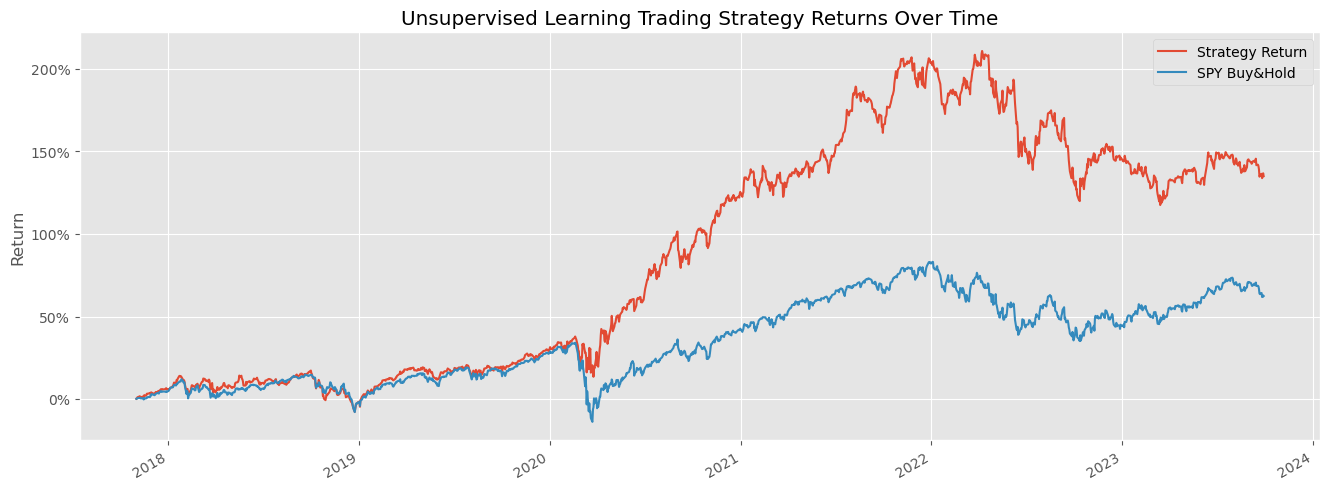|